En este notebook desarrollaré el problema de los OVNIS.

In [1]:
##paquetes para manipulacion de datos
import pandas as pd
import numpy as np
##paquetes graficos
from PIL import Image
from wordcloud import WordCloud##tiene una funcionalidad interesante para ver palabras mas repetidas
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import init_notebook_mode##para usar plotly online
init_notebook_mode(connected=True) 

In [2]:
##cargando los datos
datos=pd.read_csv('UFO_sightings.csv',low_memory=False)

LIMPIEZA DE LOS DATOS.(wow,parece que grito) 
Los datos son como tu casa, siempre debes tenerlos bien limpios!

In [3]:
#Primero quiero darme una idea de los valores nulos
datos.info()
##Me percato que hay valores faltantes en state,country,shape y comments

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              80332 non-null  object 
 1   city                  80332 non-null  object 
 2   state                 74535 non-null  object 
 3   country               70662 non-null  object 
 4   shape                 78400 non-null  object 
 5   duration (seconds)    80332 non-null  object 
 6   duration (hours/min)  80332 non-null  object 
 7   comments              80317 non-null  object 
 8   date posted           80332 non-null  object 
 9   latitude              80332 non-null  object 
 10  longitude             80332 non-null  float64
dtypes: float64(1), object(10)
memory usage: 6.7+ MB


In [4]:
##Quiero ver el encabezado de los datos para ver como puedo rellenar esos valores faltantes
datos.head(2)

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082


Al parecer los comentarios no me aportan mucho para un analisis visual, sin embargo, me encargare de limpiar las columnas de state,country, shape y comments.

In [5]:
#viendo los valores unicos de las columnas de state,country y shape, para ver que valores les puedo rellenar
print(datos.country.unique())
print(datos.state.unique())
print(datos['shape'].unique())

['us' nan 'gb' 'ca' 'au' 'de']
['tx' nan 'hi' 'tn' 'ct' 'al' 'fl' 'ca' 'nc' 'ny' 'ky' 'mi' 'ma' 'ks' 'sc'
 'wa' 'ab' 'co' 'nh' 'wi' 'me' 'ga' 'pa' 'il' 'ar' 'on' 'mo' 'oh' 'in'
 'az' 'mn' 'nv' 'nf' 'ne' 'or' 'bc' 'ia' 'va' 'id' 'nm' 'nj' 'mb' 'wv'
 'ok' 'ri' 'nb' 'vt' 'la' 'pr' 'ak' 'ms' 'ut' 'md' 'mt' 'sk' 'wy' 'sd'
 'pq' 'ns' 'qc' 'de' 'nd' 'dc' 'nt' 'sa' 'yt' 'yk' 'pe']
['cylinder' 'light' 'circle' 'sphere' 'disk' 'fireball' 'unknown' 'oval'
 'other' 'cigar' 'rectangle' 'chevron' 'triangle' 'formation' nan 'delta'
 'changing' 'egg' 'diamond' 'flash' 'teardrop' 'cone' 'cross' 'pyramid'
 'round' 'crescent' 'flare' 'hexagon' 'dome' 'changed']


Al ver los valores unicos de esas columnas, me doy cuenta que a state y country les puedo poner '??' para rellenar los valores faltantes. En shape decidi ponerle 
'unrecognizable', puesto que puede deberse a que la persona no podia ver una forma bien definida. Quizá era de noche, habia mucha niebla,o las drogas estaban fuertes(chascarrillo). En comments, los rellenaré con 'no comment'.

In [6]:
#Rellenando los valores nulos
datos['state']=datos['state'].fillna('??')
datos["country"] = datos["country"].fillna("??")
datos['shape']=datos['shape'].fillna('unrecognizable')
datos['comments']=datos['comments'].fillna('no comments')
datos.info()
#listo, ya no tenemos ningun valor faltante y no fue necesario sacrificar renglones de informacion

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              80332 non-null  object 
 1   city                  80332 non-null  object 
 2   state                 80332 non-null  object 
 3   country               80332 non-null  object 
 4   shape                 80332 non-null  object 
 5   duration (seconds)    80332 non-null  object 
 6   duration (hours/min)  80332 non-null  object 
 7   comments              80332 non-null  object 
 8   date posted           80332 non-null  object 
 9   latitude              80332 non-null  object 
 10  longitude             80332 non-null  float64
dtypes: float64(1), object(10)
memory usage: 6.7+ MB


Me doy cuenta que el formato de hora, tiene valores algo raros por el formato de horas que tiene, lo modificaré, tambien me doy cuenta que la latitude no tiene formato numerico, arreglaré eso.

In [7]:
#cambiando el formato de fecha
datos['datetime']= datos['datetime'].str.replace('24:00', '00:00')#cambiando los valores raros
datos['datetime'] = pd.to_datetime(datos.datetime, format='%m/%d/%Y %H:%M')#cambiando formato de fecha
#convirtiendo a formato numerico la latitud y longitud
datos['latitude'] = pd.to_numeric(datos.latitude,errors='coerce')  
datos['longitude '] = pd.to_numeric(datos['longitude '],errors='coerce')
##listo

ANALISIS VISUAL y estadistico 

La principal pregunta que me surge es donde y cuando es recomendable estar para poder ver un OVNI. Con el analisis que sigue intentare responderlo. Que molestos son los floppy!

Primero vere en que país es más comun ver un OVNI, par asi poder visitarlo.

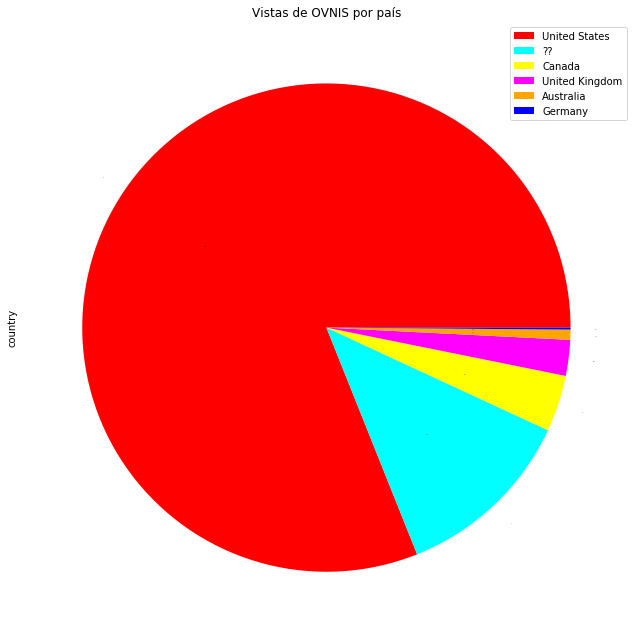

In [11]:
vistas_pais = datos.country.value_counts()  
colores = ['red','cyan','yellow','magenta','orange','blue']
vistas_pais.plot(kind = 'pie',fontsize=0,  title='Vistas de OVNIS por país', colors=colores,
                       autopct='%1.1f%%', figsize=(9,9))
plt.legend(labels=['United States','??','Canada','United Kingdom','Australia','Germany'], loc="best")
plt.tight_layout()

In [41]:
#viendo como porcentaje numericamente
datos.country.value_counts()/len(datos.country)*100

us    81.056117
??    12.037544
ca     3.734502
gb     2.371409
au     0.669721
de     0.130708
Name: country, dtype: float64

Podemos ver que el mejor lugar para ver un OVNI es estados unidos, mas del 81% de los avistamientos han sido en ese país.También, podemos ver que un 12% de los avistamientos, no se tiene informacion sobre en que país fueron. Ahora, como tenemos informacion por estado, podemos ver en que estados es mas probable encontrarse con un objeto no identificado.


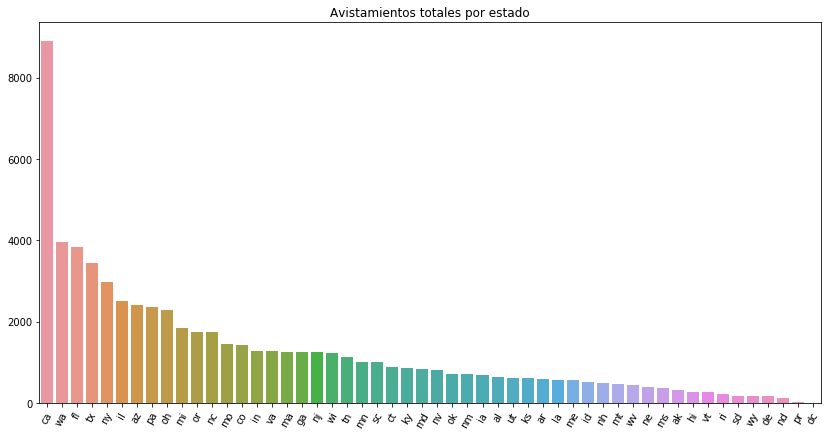

5 estados con mas avistamientos en USA:
ca    8912
wa    3966
fl    3835
tx    3447
ny    2980
Name: state, dtype: int64


In [91]:
#filtrando los datos para los estados de estados unidos
datos_usa = datos[datos['country']=='us']
#creando una serie para graficar el numero de avistamiento por estado
vistas_estados = datos_usa.state.value_counts()  
nombre_estados = vistas_estados.index 
frec_estados = [i for i in vistas_estados] 
#grafico de barras por estado
plt.figure(figsize=(14,7))
plt.xticks(rotation = 60)
plt.title('Avistamientos totales por estado')
states_plot = sns.barplot(x=nombre_estados,y=frec_estados)
plt.show()
print('5 estados con mas avistamientos en USA:')
print(vistas_estados[:5].sort_values(ascending=False))

Podemos ver que los 5 estados con mas avistamientos de OVNIS son: California, Washington,Florida,Texas y NY.

Generare un mapa bonito para los clientes del señor raro, quiza tenga una especie de empresa de turismo exotico.

In [67]:
ratio_estados = vistas_estados.values
nombre_estados = [i.upper() for i in nombre_estados]
dat = [dict(type='choropleth',locations = nombre_estados,z = ratio_estados, locationmode = 'USA-states', text = "times",
       marker = dict(line = dict (color = 'rgb(255,255,255)',width = 2) ),colorbar = dict(title = "numero avistamientos por estado"))]
estetica = dict(title = 'avistamientos por estado',geo = dict(scope='usa',projection=dict( type='albers usa' ),showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),)
fig = go.Figure(data=dat, layout=estetica)
py.iplot(fig)


Ahora vere en que ciudades han ocurrido mas avistamientos de ovnis

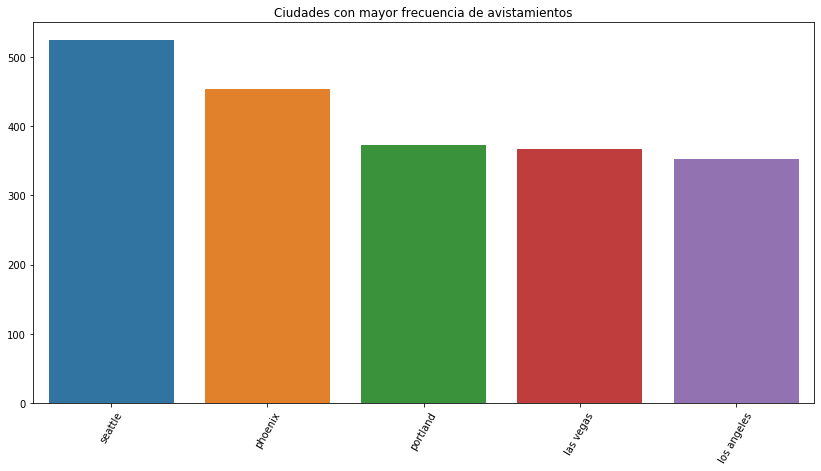

5 ciudades con mas avistamientos en USA:
seattle        524
phoenix        454
portland       373
las vegas      367
los angeles    352
Name: city, dtype: int64


In [92]:
datos_usa = datos[datos['country']=='us']
#creando una serie para graficar el numero de avistamiento por ciudad
vistas_ciudades = datos_usa.city.value_counts() 
#Graficare las ciudades con mayor frecuencia de avistamientos
vistas_ciudades=vistas_ciudades[:5].sort_values(ascending=False)
nombre_ciudades = vistas_ciudades.index 
frec_ciudades= [i for i in vistas_ciudades] 
#grafico de barras por ciudad
plt.figure(figsize=(14,7))
plt.xticks(rotation = 60)
plt.title('Ciudades con mayor frecuencia de avistamientos')
states_plot = sns.barplot(x=nombre_ciudades,y=frec_ciudades)
plt.show()
print('5 ciudades con mas avistamientos en USA:')
print(vistas_ciudades[:5].sort_values(ascending=False))

Podemos ver que las cinco ciudades con mas avistamientos de ovnis en estados unidos son: Seattle, Phoenix, Portland, Las Vegas y Los Angeles

Ok, ya sabemos en que pais, estado y ciudades es mas probable ver un ovni. Todavía nos falta saber en que mes del año es más probable verlo!

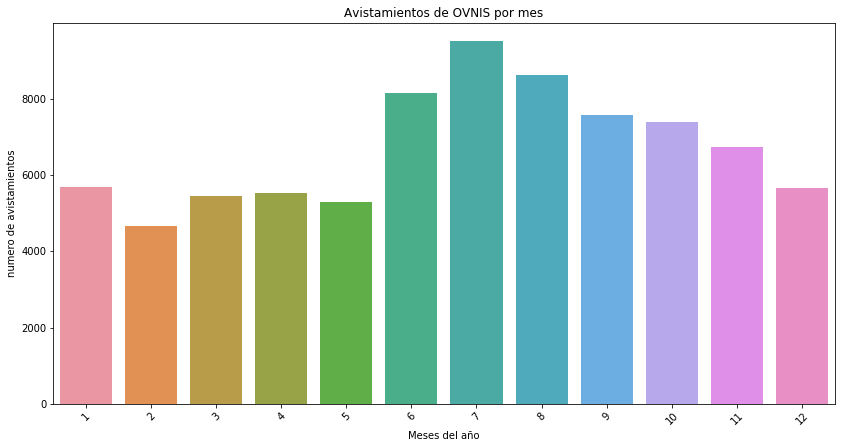

In [95]:
meses = (datos['datetime'].dt.month.value_counts()).sort_index()
mesesX = meses.index
mesesY =[i for i in meses] 
f, ax = plt.subplots(figsize=(14,7))
sns.barplot(x=mesesX, y=mesesY)
ax.set_title('Avistamientos de OVNIS por mes')
ax.set_xlabel('Meses del año')
ax.set_ylabel('numero de avistamientos')
plt.xticks(rotation=45)
plt.show()

Podemos ver que los 3 meses más comunes de avistamiento son Junio, Julio y Agosto

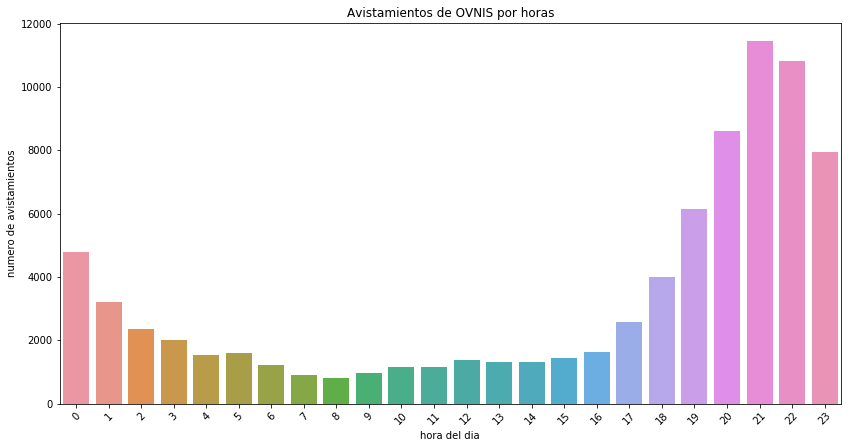

In [100]:
horas = (datos['datetime'].dt.hour.value_counts()).sort_index()
horasX = horas.index
horasY =[i for i in horas] 
f, ax = plt.subplots(figsize=(14,7))
sns.barplot(x=horasX, y=horasY)
ax.set_title('Avistamientos de OVNIS por horas')
ax.set_xlabel('hora del dia')
ax.set_ylabel('numero de avistamientos')
plt.xticks(rotation=45)
plt.show()

En cuestión de horario, es claro que en la noche es más probable avistar un OVNI. Quizá por que los extraterrestres están más activos en la noche.
Bajo esa lógica, yo soy uno.

Por último, generare un bonito poster para el señor, con las palabras mas usadas en los formas de un OVNI. Aprovechando la limpieza.
También hay que ayudarle con el marketing

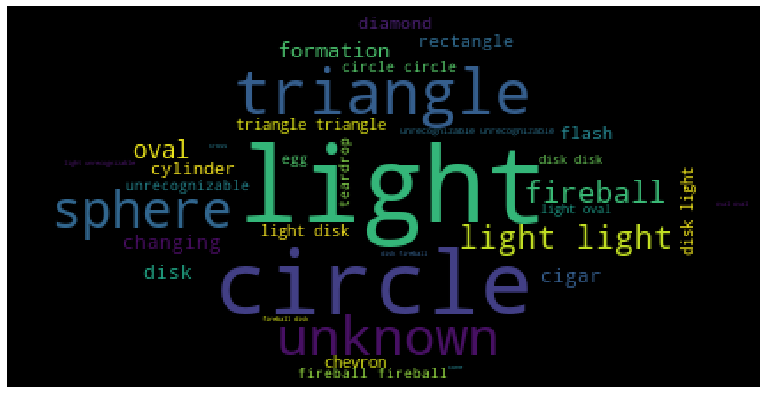

In [111]:
palabras = [i for i in datos['shape']]
palabras = " ".join(palabras)
plt.subplots(figsize=(15,7))
wave_mask = np.array(Image.open( "plato2.jpg"))
wordcloud = WordCloud(mask=wave_mask, background_color='black', width=1000,height=500).generate(palabras)
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('poster.png')
plt.show()

Como conclusión y respuesta para el cliente, tendría que ir a estados unidos, al estado de california o a una de las 5 ciudades con mas avistamientos, para ver un OVNI o entrevistar a alguien que los haya visto. Hablando de epoca del año, el verano parece ser la epoca en la que es mas probable que pueda ver un ovni. Por ultimo, le recomendaria que fuera a las zonas en la noche, especificamente a partir de las 7 pm.